## Library 


Credit to :
https://github.com/aman5319/Multi-Label/blob/master/Classify_scenes.ipynb

In [7]:
import cv2
import torch
import os
import random
import math
import glob 
import pathlib
import csv, PIL
import time, zipfile
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from PIL import Image
from os import listdir
from torchvision import*

%matplotlib inline

In [2]:
df = pd.read_csv('/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/final_csv2.csv')
df.head()

,converted_filename,Effusion,Consolidations,B-lines,Healthy
0,Cov_combatting_Image1_frame_003.jpg,0,0,1,1
1,Cov_combatting_Image1_frame_006.jpg,0,0,1,1
2,Cov_combatting_Image1_frame_009.jpg,0,0,1,1
3,Cov_combatting_Image1_frame_012.jpg,0,0,1,1
4,Cov_combatting_Image1_frame_015.jpg,0,0,1,1


Vir_blines_advancesVid9_frame_117.jpg


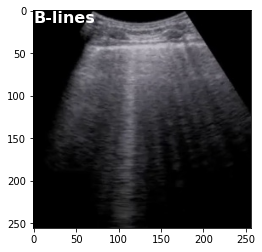

In [4]:
classLabels = ["Effusion", "Consolidations", "B-lines", "Healthy"]
def visualizeImage(idx):
    fd = df.iloc[idx]
    image = fd.converted_filename
    label = fd[1:].tolist()
    print(image)
    try:
        image = Image.open("/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/"+image)
    except:
        pass 
    
    fig,ax = plt.subplots()
    ax.imshow(image)
    ax.grid(False)
    classes =  np.array(classLabels)[np.array(label,dtype=np.bool)]
    for i , s in enumerate(classes):
        ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')
    plt.show()
    
visualizeImage(605)

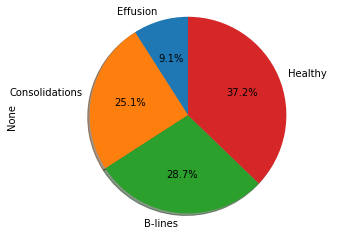

In [5]:
fig1, ax1 = plt.subplots()
df.iloc[:,1:].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

<AxesSubplot:>

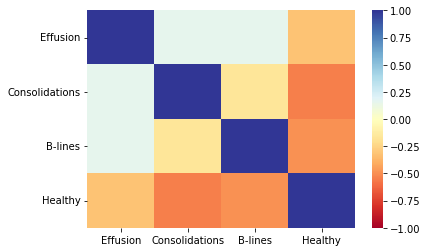

In [6]:
import seaborn as sns
sns.heatmap(df.iloc[:,1:].corr(), cmap="RdYlBu", vmin=-1, vmax=1)
# looks like there is no correlation between the labels

In [9]:
#Images in the dataset have different sizes to lets take a mean size while resizing 224*224
l= []

for i in df.converted_filename:
    with Image.open(Path("/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/")/i) as f:
        l.append(f.size)
        
np.array(l).mean(axis=0),np.median(np.array(l) , axis=0)

(array([256., 256.]), array([256., 256.]))

## 02 Dataloader

In [39]:
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
import pandas as pd
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
) 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"'{device}' is avilable.")

'cuda' is avilable.


In [94]:
img_path = "/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/"

In [138]:
from skimage import io

class USDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(self.annotations.iloc[index, 1:].astype(int))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [139]:
transformations = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224, 224)), transforms.ToTensor()])

In [140]:
dataset = USDataset(
    csv_file="/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/final_csv2.csv",
    root_dir="/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/",
    transform=transformations,
)

In [141]:
train_loader = DataLoader(dataset = dataset, batch_size = 64, shuffle = True)

In [142]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

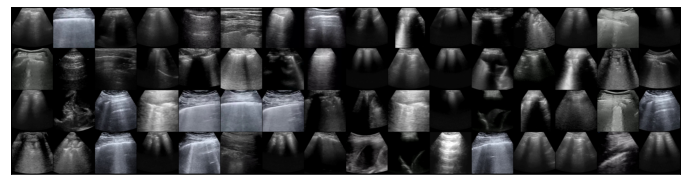

In [143]:
show_batch(train_loader)

## 03 Std and Mean

In [101]:
def get_mean_std(loader):
    # Var[x] = E[x**2] - E[X]**2
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
        
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    
    return mean, std

mean, std = get_mean_std(train_loader)
print(mean, std)

print(f" The mean value of the images : {mean},\n Standard Deviation values are : {std}")

tensor([0.1864, 0.1885, 0.1938]) tensor([0.1934, 0.1961, 0.2036])
 The mean value of the images : tensor([0.1864, 0.1885, 0.1938]),
 Standard Deviation values are : tensor([0.1934, 0.1961, 0.2036])


> 이미지 수가 부족함으로 굳이 의미 없다


## 04 Splitting Data

In [102]:
transformations = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224, 224)), 
                                      transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [103]:
dataset = USDataset(
    csv_file="/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/final_csv2.csv",
    root_dir="/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/",
    transform=transformations,
)

In [104]:
train_loader = DataLoader(dataset = dataset, batch_size = 64, shuffle = True)

In [106]:
valid_no = int(len(dataset)*0.2) 
valid_no

1450

In [107]:
trainset ,valset  = random_split( dataset , [len(dataset) -valid_no  ,valid_no])
print(f"trainset len {len(trainset)} valset len {len(valset)}")

trainset len 5802 valset len 1450


In [108]:
dataloader = {"train":DataLoader(trainset , shuffle=True , batch_size=batch_size),
              "val": DataLoader(valset , shuffle=True , batch_size=batch_size)}

In [120]:
train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=True)

In [121]:
# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 32
num_epochs = 10

In [149]:
# Model
model = torchvision.models.resnet50(pretrained=True)

In [150]:
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)
## freeze the entire convolution base
for param in model.parameters():
    param.requires_grad_(False)

2048


In [151]:
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
    features_lst = [num_features , num_features//2 , num_features//4]
    layers = []
    for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
        layers.append(nn.Linear(in_f , out_f))
        layers.append(activation_func())
        layers.append(nn.BatchNorm1d(out_f))
        if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
    layers.append(nn.Linear(features_lst[-1] , number_classes))
    return nn.Sequential(*layers)

top_head = create_head(num_features , len(classLabels)) # because ten classes
model.fc = top_head # replace the fully connected layer

In [152]:
model.to(device)
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss() # Multi-label
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [158]:
from tqdm import trange

for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        model.to(device)
        scores = model(data)
        loss = criterion(scores, targets.float())
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

Cost at epoch 0 is 0.02655465764058917


KeyboardInterrupt: 

> https://blog.51cto.com/u_13977270/3397689

In [159]:
from tqdm import trange
from sklearn.metrics import precision_score,f1_score

def train(model , data_loader , criterion , optimizer ,scheduler, num_epochs=5):
    for epoch in trange(num_epochs,desc="Epochs"):
        result = []
        for phase in ['train', 'val']:
            if phase=="train":     # put the model in training mode
                model.train()
                scheduler.step()
            else:     # put the model in validation mode
                model.eval()
       
            # keep track of training and validation loss
            running_loss = 0.0
            running_corrects = 0.0  
            
            for data , target in data_loader[phase]:
                #load the data and target to respective device
                data , target = data.to(device)  , target.to(device)
                
                with torch.set_grad_enabled(phase=="train"):
                    #feed the input
                    output = model(data)
                    #calculate the loss
                    loss = criterion(output,target.float())
                    preds = torch.sigmoid(output).data > 0.5
                    preds = preds.to(torch.float32)
                    
                    if phase=="train"  :
                        # backward pass: compute gradient of the loss with respect to model parameters 
                        loss.backward()
                        # update the model parameters
                        optimizer.step()
                        # zero the grad to stop it from accumulating
                        optimizer.zero_grad()
                        
                # statistics
                running_loss += loss.item() * data.size(0)
                running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)
                
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = running_corrects / len(data_loader[phase].dataset)
            
            result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        print(result)

In [160]:
train(model,dataloader , criterion, optimizer,sgdr_partial,num_epochs=10)

Epochs:  10%|█         | 1/10 [00:40<06:02, 40.30s/it]

['train Loss: 0.1049 Acc: 0.9319', 'val Loss: 0.0351 Acc: 0.9795']


Epochs:  20%|██        | 2/10 [01:19<05:19, 39.95s/it]

['train Loss: 0.0750 Acc: 0.9538', 'val Loss: 0.0923 Acc: 0.9840']


Epochs:  30%|███       | 3/10 [01:59<04:39, 39.98s/it]

['train Loss: 0.0647 Acc: 0.9585', 'val Loss: 0.1157 Acc: 0.9874']


Epochs:  40%|████      | 4/10 [02:38<03:58, 39.81s/it]

['train Loss: 0.0547 Acc: 0.9685', 'val Loss: 0.1205 Acc: 0.9899']


Epochs:  50%|█████     | 5/10 [03:17<03:17, 39.57s/it]

['train Loss: 0.0587 Acc: 0.9636', 'val Loss: 0.0203 Acc: 0.9923']


Epochs:  60%|██████    | 6/10 [03:57<02:38, 39.68s/it]

['train Loss: 0.0512 Acc: 0.9671', 'val Loss: 0.0838 Acc: 0.9933']


Epochs:  70%|███████   | 7/10 [04:37<01:59, 39.67s/it]

['train Loss: 0.0431 Acc: 0.9734', 'val Loss: 0.0713 Acc: 0.9908']


Epochs:  80%|████████  | 8/10 [05:17<01:19, 39.63s/it]

['train Loss: 0.0444 Acc: 0.9729', 'val Loss: 0.0143 Acc: 0.9933']


Epochs:  90%|█████████ | 9/10 [05:56<00:39, 39.72s/it]

['train Loss: 0.0412 Acc: 0.9739', 'val Loss: 0.0394 Acc: 0.9930']


Epochs: 100%|██████████| 10/10 [06:37<00:00, 39.70s/it]

['train Loss: 0.0448 Acc: 0.9724', 'val Loss: 0.5637 Acc: 0.9909']


## Saving & Loading model

In [161]:
def createCheckpoint(filename=Path("./LatestCheckpoint.pt")):
    checkpoint = {'epoch': 5,
                  'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,
  } # save all important stuff
    torch.save(checkpoint , filename)
createCheckpoint()

In [162]:
# Load
'''
First Intialize the model and then just load it
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

'''

checkpoint = torch.load(Path("./LatestCheckpoint.pt"))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']

model.eval() ## or model.train()
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [163]:
image , label = next(iter(dataloader["val"]))
image = image.to(device)
label = label.to(device)
output = 0
with torch.no_grad():
    output = model(image)
    output = torch.sigmoid(output)
output = output>0.2

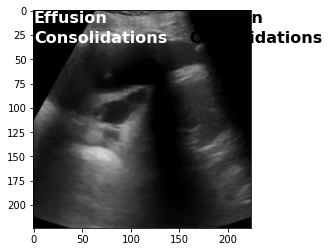

In [164]:
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
def denormalize(image):
    image = image.to("cpu").clone().detach()
    image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
    image = image.permute(1,2,0) 
    image = torch.clamp(image,0,1)
    return image.numpy()

def visualize(image , actual , pred):
    fig,ax = plt.subplots()
    ax.imshow(denormalize(image))
    ax.grid(False)
    classes =  np.array(classLabels)[np.array(actual,dtype=np.bool)]
    for i , s in enumerate(classes):
        ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')
        
    classes =  np.array(classLabels)[np.array(pred,dtype=np.bool)]
    for i , s in enumerate(classes):
        ax.text(160 , i*20  , s , verticalalignment='top', color="black", fontsize=16, weight='bold')
    plt.show()

visualize(image[1] , label[1].tolist() , output[1].tolist())